# **Redes neurais - Entrega 1 - Classificação utilizando XLNet**

>  Este é o notebook referênte à classificação de tweets de discurso de ódio utilizando o modelo XLNet para o processamento de texto.



## **Imports, definições e configuração do ambiente**

In [ ]:
!pip install kagglehub
!pip install numpy
!pip install torch
!pip install transformers datasets scikit-learn pandas matplotlib --quiet
!pip install transformers
!pip install --upgrade datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import json
import re
from collections import Counter
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import kagglehub
from datasets import Dataset, DatasetDict
from transformers import XLNetTokenizer, XLNetModel, XLNetForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch import nn
import wandb
import seaborn as sns

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1
Tesla T4


In [ ]:
device

device(type='cuda')

Checkpoint do modelo

In [ ]:
# Modelo
model_checkpoint = "xlnet/xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Funções

In [ ]:
# Funções de pré-processamento ---------------------------------------------------------------

def clean_text(text):
    """Remove menções, hashtags, URLs e espaços extras do texto."""
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def process_and_binarize_example(example):
    """Aplica a limpeza e a binarização."""

    example['text'] = clean_text(example['text'])

    # Calcula o voto majoritário
    majority_vote = Counter(example['labels_multi']).most_common(1)[0][0]

    # Binariza o rótulo: 0 para "Não é hate", 1 para qualquer tipo de "Hate"
    example['label'] = 0 if majority_vote == 0 else 1

    return example

def tokenize_function(examples):
    """Aplica a tokenização aos textos."""
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

#---------------------------------------------------------------------------------------------

def compute_binary_metrics(pred):
    """Calcula métricas focadas no problema binário."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Usamos average='binary' para focar na performance da classe positiva (1: "Hate")
    # Explicitamente definimos zero_division=0 para lidar com casos onde não há predições positivas
    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary', zero_division=0)
    recall = recall_score(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

## **Carregamento dos dados**

Download do conjunto de dados

In [ ]:
dataset = kagglehub.dataset_download("victorcallejasf/multimodal-hate-speech")
dataset

'/kaggle/input/multimodal-hate-speech'

In [ ]:
json_gt_path = os.path.join(dataset, "MMHS150K_GT.json")
splits_paths = {
    "Treino": os.path.join(dataset, "splits", "train_ids.txt"),
    "Validação": os.path.join(dataset, "splits", "val_ids.txt"),
    "Teste": os.path.join(dataset, "splits", "test_ids.txt"),
}

# arquivo JSON principal com todas as anotações
with open(json_gt_path, 'r') as f:
    full_data_json = json.load(f)

print("Dados carregados.")

Dados carregados.


## **Pré-processamento**

In [ ]:
# Fluxo de processamento

all_data_list = [{'tweet_id': k, 'text': v['tweet_text'], 'labels_multi': v['labels']} for k, v in full_data_json.items()]
full_dataset = Dataset.from_list(all_data_list)

split_ids_set = {k.lower(): set(open(v, 'r').read().splitlines()) for k, v in splits_paths.items()}
raw_datasets = DatasetDict({
    'train': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['treino']),
    'validation': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['validação']),
    'test': full_dataset.filter(lambda x: x['tweet_id'] in split_ids_set['teste'])
})

# Limpeza e binarização
processed_datasets = raw_datasets.map(process_and_binarize_example, remove_columns=['labels_multi', 'tweet_id'])

# tokenização
tokenized_datasets = processed_datasets.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

print("Pipeline de processamento concluído.")
print("\nEstrutura do Dataset Final:")
print(tokenized_datasets)

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Filter:   0%|          | 0/149823 [00:00<?, ? examples/s]

Map:   0%|          | 0/134823 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/134823 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Pipeline de processamento concluído.

Estrutura do Dataset Final:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 134823
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10000
    })
})


## **Análise de distribuição das classes**

Distribuição das Classes Após Binarização:
     Classe  Quantidade
0      Hate       26361
1  Não Hate      108462

Proporção 'Não Hate': 80.45%
Proporção 'Hate':     19.55%


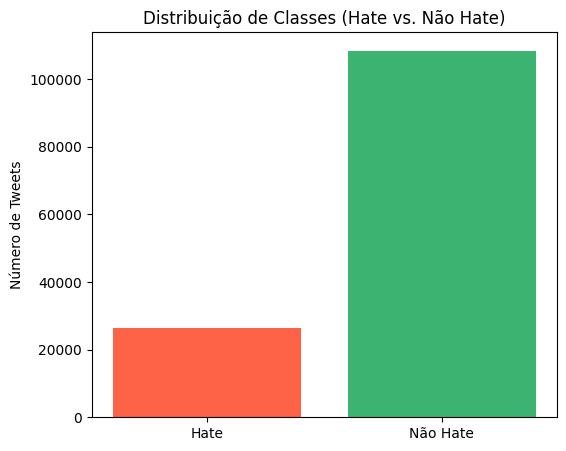

In [ ]:
# Análise de Distribuição Binária
train_labels_binary = processed_datasets['train']['label']
binary_labels_map = {0: "Não Hate", 1: "Hate"}
binary_label_counts = Counter(train_labels_binary)

df_binary_dist = pd.DataFrame({
    'Classe': [binary_labels_map[label] for label in binary_label_counts.keys()],
    'Quantidade': list(binary_label_counts.values())
})

print("Distribuição das Classes Após Binarização:")
print(df_binary_dist)
print(f"\nProporção 'Não Hate': {binary_label_counts[0] / len(train_labels_binary):.2%}")
print(f"Proporção 'Hate':     {binary_label_counts[1] / len(train_labels_binary):.2%}")

plt.figure(figsize=(6, 5))
plt.bar(df_binary_dist['Classe'], df_binary_dist['Quantidade'], color=['tomato', 'mediumseagreen'])
plt.title('Distribuição de Classes (Hate vs. Não Hate)')
plt.ylabel('Número de Tweets')
plt.show()

Para tratar o desbalanceamento das classes, aplicaremos _undersampling_ ao conjunto de treino.

Distribuição das Classes no Treino Após Undersampling:
label
1    26361
0    26361
Name: count, dtype: int64


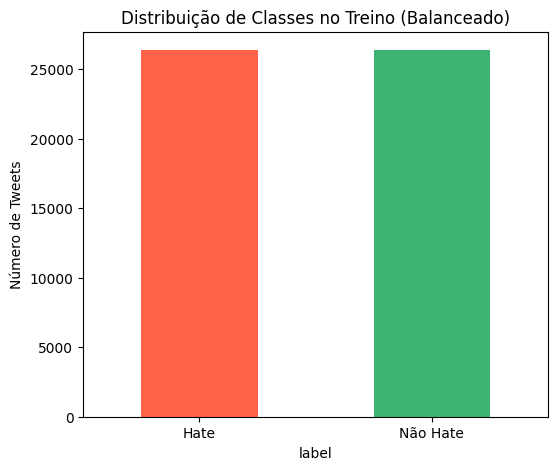

In [ ]:
# Aplicando undersampling ao conjunto de treino

df_train = processed_datasets['train'].to_pandas()

# Separamento as classes
df_hate = df_train[df_train['label'] == 1]
df_not_hate = df_train[df_train['label'] == 0]

# Classe majoritária ("Não Hate") para ter o mesmo tamanho da minoritária
n_hate_samples = len(df_hate)
df_not_hate_undersampled = df_not_hate.sample(n=n_hate_samples, random_state=42)
df_train_balanced = pd.concat([df_hate, df_not_hate_undersampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Distribuição das Classes no Treino Após Undersampling:")
print(df_train_balanced['label'].value_counts())

balanced_train_dataset = Dataset.from_pandas(df_train_balanced)

plt.figure(figsize=(6, 5))
df_train_balanced['label'].value_counts().plot(kind='bar', color=['tomato', 'mediumseagreen'])
plt.title('Distribuição de Classes no Treino (Balanceado)')
plt.xticks(ticks=[0, 1], labels=['Hate', 'Não Hate'], rotation=0)
plt.ylabel('Número de Tweets')
plt.show()

## **Treinamento**

In [ ]:
# Carrega o modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="resultados/xlnet-resultado",
    overwrite_output_dir=True,

    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,

    seed=seed,
    weight_decay=0.0,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-08,

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",

    logging_dir="logs/log",
    logging_steps=100,
    report_to="none",  # Disable Weights & Biases reporting

    lr_scheduler_type="linear",     # scheduler linear conforme especificado
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,    # seu dataset de treino
    eval_dataset=val_dataset,       # seu dataset de validação
    tokenizer=tokenizer,
    compute_metrics=compute_binary_metrics # Corrected function name
)

/tmp/ipython-input-20-682558595.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
wandb.init()
trainer.train()
trainer.save_model("./resultados/modelo")

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.443600,0.733692,0.634600,0.396831,0.766582,0.267706
2,0.426600,0.735171,0.651800,0.458139,0.760331,0.327840
3,0.418600,0.775358,0.635200,0.400788,0.763454,0.271715


## **Resultados**

In [ ]:
resultados = trainer.evaluate(test_dataset)


Gerando previsões para a Matriz de Confusão com Undersampling...


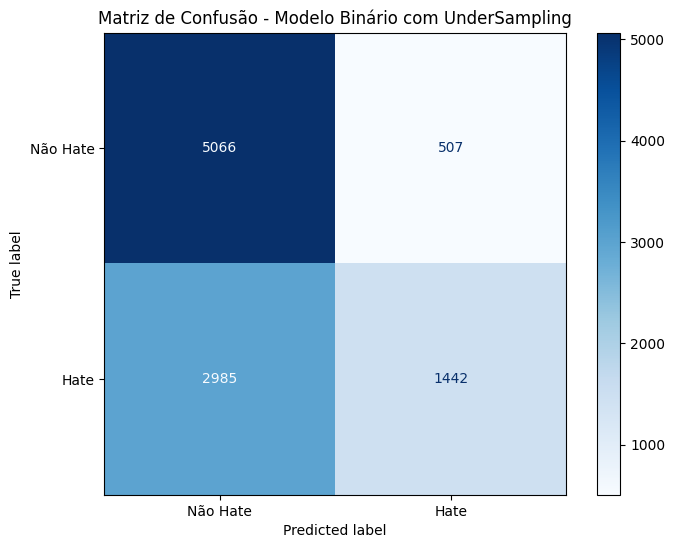

In [ ]:
print("\nGerando previsões para a Matriz de Confusão com Undersampling...")
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


cm = confusion_matrix(labels, preds, labels=list(binary_labels_map.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(binary_labels_map.values()))

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Matriz de Confusão - Modelo Binário com UnderSampling")
plt.grid(False)
plt.show()

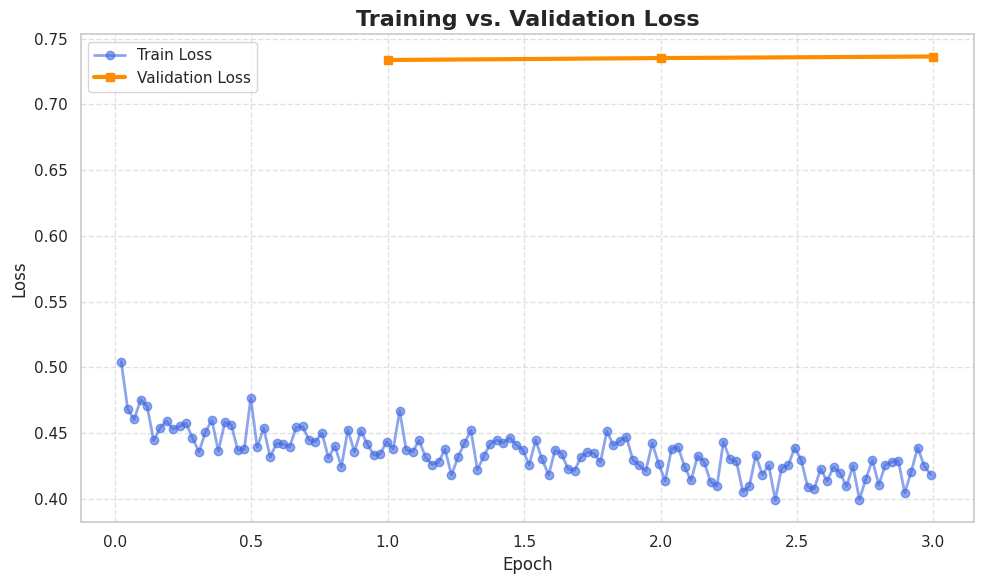

In [ ]:
log_history = trainer.state.log_history

epochs, train_loss = [], []
for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])

train_epochs = epochs[:len(train_loss)]

eval_logs = [(round(log['epoch']), log['eval_loss']) for log in log_history if 'eval_loss' in log and 'epoch' in log]

eval_dict = {}
for epoch, loss in eval_logs:
    eval_dict[epoch] = loss  # sobrescreve mantendo só o último da época

eval_epochs = sorted(eval_dict.keys())
eval_loss = [eval_dict[ep] for ep in eval_epochs]

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

plt.plot(train_epochs, train_loss, label="Train Loss", color="royalblue", linewidth=2, marker='o', alpha=0.6)
plt.plot(eval_epochs, eval_loss, label="Validation Loss", color="darkorange", linewidth=3, marker='s')

plt.title("Training vs. Validation Loss", fontsize=16, weight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.legend(frameon=True, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
tabela_resultados = {
    "Métrica": ["F1", "Recall", "Precisão", "Acurácia"],
    "Resultado": [
        resultados.get('eval_f1'),
        resultados.get('eval_recall'),
        resultados.get('eval_precision'),
        resultados.get('eval_accuracy')
    ]
}

tabela = pd.DataFrame(tabela_resultados)
display(tabela)

,Métrica,Resultado
0,F1,0.452321
1,Recall,0.325728
2,Precisão,0.739867
3,Acurácia,0.650800


## **Conclusão**

Diante dos resultados obtidos, é possível concluir que as métricas revelam um desempenho insatisfatório — especialmente o recall e o F1-score. Apesar de a precisão ter sido relativamente alta, sua baixa sensibilidade evidencia uma tendência a ignorar muitas instâncias relevantes da classe de *hate*. Além disso, a curva de validação manteve-se praticamente constante e elevada ao longo das épocas, o que pode sinalizar *underfitting* e sugere que o modelo não conseguiu generalizar bem para os dados de validação. É importante destacar também que limitações de hardware influenciaram diretamente na profundidade dos experimentos, limitando, por exemplo, o número de épocas e a exploração mais ampla de hiperparâmetros que poderiam ter contribuído para um ajuste mais eficaz. Considerando esses fatores, e levando em conta os outros modelos testados ao longo do projeto, é provável dizer que a XLNet não será a principal abordagem para a próxima etapa.
